# Introduction
<div style="width:100%;height:6px;background-color:Black;"></div>

### Pressure Swing Distillation

Separation of the Methanol and Acetone minimum temperature azeotrope by using the pressure sensitivity of the azeotropic composition of this mixture by operating two columns at different pressures, adapted from [Luyben et al. Ind.Eng.Chem.Res. (2008) 47 pp. 2696-2707.](http://pubs.acs.org/doi/pdf/10.1021/ie701695u).

The number of stages in this flowsheet differs from the specifications used in the ChemSep example.

[Link to the flowsheet drawing](http://www.chemsep.org/downloads/data/Pressure_Swing_MA_iecr47p2696.png)

# .NET Initialization
<div style="width:100%;height:6px;background-color:Black;"></div>

In [1]:
import clr
clr.AddReference(r"..\bin\MiniSim.Core")

import MiniSim.Core.Expressions as expr
from  MiniSim.Core.Flowsheeting import MaterialStream, Flowsheet
import MiniSim.Core.Numerics as num
from MiniSim.Core.UnitsOfMeasure import Unit, SI, METRIC, PhysicalDimension
from MiniSim.Core.ModelLibrary import Flash, Heater, Mixer, Splitter, EquilibriumStageSection
import MiniSim.Core.PropertyDatabase as chemsep
from MiniSim.Core.Reporting import Generator, StringBuilderLogger
from MiniSim.Core.Thermodynamics import ThermodynamicSystem

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams['grid.color'] = 'k'

# General Objects Instantiation
<div style="width:100%;height:6px;background-color:Black;"></div>

In [4]:
Database = chemsep.ChemSepAdapter()
logger = StringBuilderLogger();
reporter = Generator(logger)

# Set up Thermodynamics

In [5]:
sys= ThermodynamicSystem("Test2","NRTL", "default")

sys.AddComponent(Database.FindComponent("Acetone"))
sys.AddComponent(Database.FindComponent("Methanol"))
Database.FillBIPs(sys)

kmolh=Unit.Make([SI.kmol],[SI.h])
tonh=Unit.Make([METRIC.ton],[SI.h])

sys.VariableFactory.SetOutputDimension(PhysicalDimension.HeatFlow, SI.MW)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.Pressure, METRIC.bar)
sys.VariableFactory.SetOutputDimension(PhysicalDimension.MassFlow, tonh)

# Analysis of the Thermo System

In [6]:
def thermoAnalysis(psys):
    numComps=len(sys.Components)
    names=sys.GetComponentIds()

    numSteps=20    
    mixture= MaterialStream("Mix", sys)
    mixture.Specify("VF",0.0)
    mixture.Specify("P",psys, METRIC.mbar)
    for c in names:
        mixture.Specify("n["+c+"]",1.0)
    mixture.InitializeFromMolarFlows()
    mixture.FlashPZ()

    test= Flowsheet("test")
    test.AddMaterialStream(mixture)

    solver= num.DecompositionSolver(logger)
    result=solver.Solve(test)

    fig,axs=plt.subplots(numComps,numComps,figsize=(8,8))
    for i in range(numComps):
        for j in range(numComps):       
            if j!=i:
                xvec=[]
                yvec=[]
                for c in range(numSteps):
                    for k in range(numComps):                    
                        mixture.Specify("n["+names[k]+"]",0.0)
                    mixture.Specify("n["+names[i]+"]",c/(numSteps-1))
                    mixture.Specify("n["+names[j]+"]",1.0-c/(numSteps-1))
                    mixture.InitializeFromMolarFlows()
                    mixture.FlashPZ()
                    solver.Solve(test)                               
                    xvec.append(mixture.GetVariable('xL['+names[j]+']').Val())               
                    yvec.append(mixture.GetVariable('xV['+names[j]+']').Val())               
                axs[i,j].plot(xvec, yvec)
                axs[i,j].plot(xvec, xvec)              
                axs[i,j].set_title(names[j] +' in '+names[i])
                axs[i,j].set_xlabel('$x_{'+names[j]+'}$')       
                axs[i,j].set_ylabel('$y_{'+names[j]+'}$')
                axs[i, j].set_aspect('equal', 'box')
            else:
                axs[i, j].axis('off')        

    plt.tight_layout()
    logger.Flush()
    plt.suptitle('(x,y)-Diagram at '+str(round(psys,2))+' mbar', y=1.05);

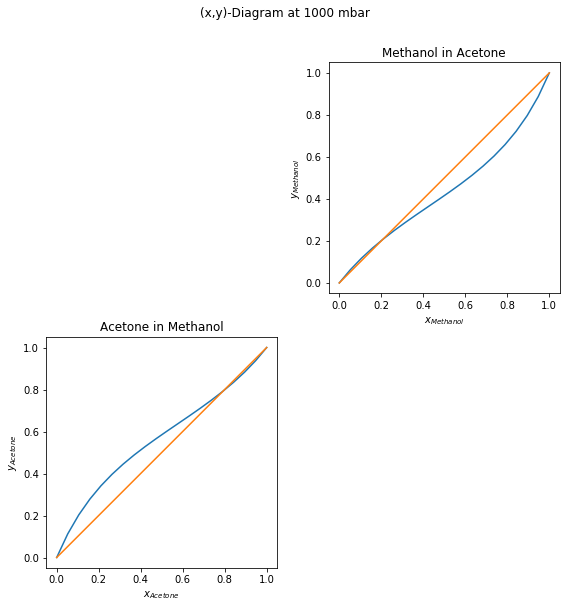

In [7]:
thermoAnalysis(1000)

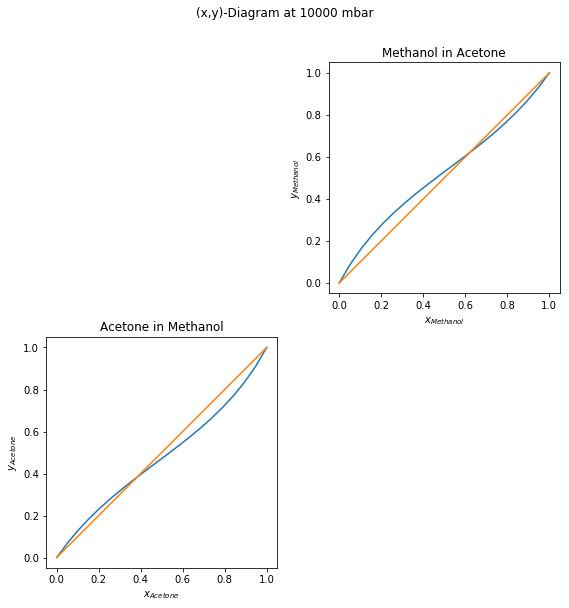

In [8]:
thermoAnalysis(10000)

# Low pressure column

In [9]:
Feed = (MaterialStream("Feed", sys)
    .Specify("T",43, METRIC.C)
    .Specify("P",1, METRIC.bar)
    .Specify("n[Acetone]", 270, kmolh)
    .Specify("n[Methanol]", 270, kmolh)
    .InitializeFromMolarFlows()
    .FlashPT())

Recycle = (MaterialStream("Recycle", sys)
    .Specify("T",54, METRIC.C)
    .Specify("P",10, METRIC.bar)
    .Specify("n[Acetone]",10, kmolh)
    .Specify("n[Methanol]", 170, kmolh)
    .InitializeFromMolarFlows()
    .FlashPZ())

S01 = MaterialStream("S01", sys)
S02 = MaterialStream("S02", sys)
S03 =(MaterialStream("S03", sys)
    .Init("T", 51, METRIC.C)
    .Init("P", 1, METRIC.bar)
    .Init("n[Acetone]",50, kmolh)
    .Init("n[Methanol]", 50, kmolh))

S04 = MaterialStream("S04", sys)
S05 = (MaterialStream("S05", sys)
    .Init("T", 61, METRIC.C)
    .Init("P", 1, METRIC.bar)
    .Init("n[Acetone]",2, kmolh)
    .Init("n[Methanol]", 100, kmolh))

Methanol = MaterialStream("Methanol", sys)
D1 = MaterialStream("D1", sys)

In [10]:
C1 = (EquilibriumStageSection("C1",sys,52)
        .Connect("VIn", S05)
        .Connect("LIn", S03)
        .Connect("VOut", S01)
        .Connect("LOut", S04)
        .ConnectFeed(Feed,37)
        .ConnectFeed(Recycle,41)
        .MakeAdiabatic()
        .MakeIsobaric()
        .FixStageEfficiency(1.0)
        .Initialize(2.3,0.25,logger))

REB1 =(Flash("REB1",sys)
        .Connect("In", S04)
        .Connect("Vap", S05)
        .Connect("Liq", Methanol)
        .Specify("P", 1, METRIC.bar)
        .Specify("VF",0.7)
        .Initialize())

COND1 = (Heater("COND1",sys)
        .Connect("In", S01)
        .Connect("Out", S02)
        .Specify("P",1, METRIC.bar)
        .Specify("VF",0)
        .Initialize())

RefluxRatio1=2.36
REFSPL1 = (Splitter("REFSPL1",sys)
        .Connect("In", S02)
        .Connect("Out1", S03)
        .Connect("Out2", D1)
        .Specify("DP",0, METRIC.bar)
        .Specify("K",RefluxRatio1/(1.0+RefluxRatio1))
        .Initialize())

C1.Initialize(1.0,0.25,logger)
logger.Flush();

In [11]:
flowsheet= (Flowsheet("Flow")
            .AddMaterialStreams(Feed, Recycle, S01,S02,S03,D1,S04,S05, Methanol)
            .AddUnits(C1, REB1, COND1, REFSPL1))

In [12]:
solver= num.DecompositionSolver(logger)

solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=846, E=846, Blocks=238, Singletons=230
Block Statistics:
   # Var # Blocks % Blocks
       1      230  96,64 %
       5        4   1,68 %
       6        3   1,26 %
     578        1   0,42 %
Problem Flow was successfully solved (0,345 seconds)



In [13]:
reporter.Report(flowsheet, 5, False)
print (logger.Flush())


Report for flowsheet Flow

Material Streams

System                    Test2      

Property                  Unit               Feed      Recycle          S01          S02          S03

Temperature               °C              43.0000     136.0140      55.0442      55.0345      55.0345
Pressure                  bar              1.0000      10.0000       1.0000       1.0000       1.0000
Vapor Fraction            mol/mol          0.0000       0.0000       1.0000       0.0000       0.0000
Specific Enthalpy         kJ/kmol     -32510.3979  -23755.2480    2085.9629  -29148.4951  -29148.4951
Phase                                      Liquid  LiquidVapor        Vapor  BubblePoint  LiquidVapor
Density                   kmol/cum        17.0475      19.8074       0.0366      14.5417      14.5417
Mass Density              kg/cum         768.1702     663.3175       1.8978     753.0426     753.0426
Volume Flow               cum/h           31.6761       9.0875   29135.9738      73.4260      51.5

# Add High pressure column

In [14]:
S06 = MaterialStream("S06", sys)
S07 = MaterialStream("S07", sys)
S08 = (MaterialStream("S08", sys)
        .Init("T", 54, METRIC.C)
        .Init("P", 10, METRIC.bar)
        .Init("n[Acetone]",50, kmolh)
        .Init("n[Methanol]", 50, kmolh))

S09 = MaterialStream("S09", sys)

S10 = (MaterialStream("S10", sys)
        .Init("T", 140, METRIC.C)
        .Init("P", 10, METRIC.bar)
        .Init("n[Acetone]",100, kmolh)
        .Init("n[Methanol]", 2, kmolh))

Acetone = MaterialStream("Acetone", sys)
D2 = MaterialStream("D2", sys)

C2 = (EquilibriumStageSection("C2",sys,61)
        .Connect("VIn", S10)
        .Connect("LIn", S08)
        .Connect("VOut", S06)
        .Connect("LOut", S09)
        .ConnectFeed(D1,41)
        .MakeAdiabatic()
        .MakeIsobaric()
        .FixStageEfficiency(1.0)
        .Initialize(3.11,0.1,logger))

REB2 = (Flash("REB2",sys)
        .Connect("In", S09)
        .Connect("Vap", S10)
        .Connect("Liq", Acetone)
        .Specify("P",10, METRIC.bar)
        .Specify("VF",0.7)
        .Initialize())

COND2 = (Heater("COND2",sys)
        .Connect("In", S06)
        .Connect("Out", S07)
        .Specify("P",10, METRIC.bar)
        .Specify("VF",0)
        .Initialize())

RefluxRatio2=3.11
REFSPL2 = (Splitter("REFSPL2",sys)
        .Connect("In", S07)
        .Connect("Out1", D2)
        .Connect("Out2", S08)
        .Specify("DP",0, METRIC.bar)
        .Specify("K",1-RefluxRatio2/(1.0+RefluxRatio2))
        .Initialize())

C2.Solve()
REB2.Solve()
COND2.Solve()
REFSPL2.Solve()
C2.Initialize(3.11,0.1,logger)
logger.Flush();

In [15]:
flowsheet.AddMaterialStreams(S06,S07,S08,D2,S09,S10,Acetone)
flowsheet.AddUnits(C2, REB2, COND2, REFSPL2);

In [16]:
solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=1743, E=1743, Blocks=445, Singletons=431
Block Statistics:
   # Var # Blocks % Blocks
       1      431  96,85 %
       5        6   1,35 %
       6        6   1,35 %
     578        1   0,22 %
     668        1   0,22 %
Problem Flow was successfully solved (0,334 seconds)



# Close Recycle

The stream recycle was fixed while we performed the startup calculations. Now we connect the recycle stream with the distillate stream of C2 to close the loop. We use a simple adiabatic heater to close the mass and energy balance.

In [17]:
Recycle.Unfix()

RECY01 = (Heater("RECY01",sys)
    .Connect("In", D2)
    .Connect("Out", Recycle)
    .Specify("DP",9, METRIC.bar)
    .Specify("Q",0, SI.kW)
    .Initialize()
    .Solve())

flowsheet.AddUnit(RECY01);

In [18]:
solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=1750, E=1750, Blocks=426, Singletons=413
Block Statistics:
   # Var # Blocks % Blocks
       1      413  96,95 %
       5        5   1,17 %
       6        7   1,64 %
    1270        1   0,23 %
Problem Flow was successfully solved (0,428 seconds)



# Reach Specifications

In [19]:
REB1.Unspecify("VF")
REB2.Unspecify("VF")
Methanol.GetVariable("x[Methanol]").Fix(0.99)
Acetone.GetVariable("x[Acetone]").Fix(0.99)

In [20]:
solver.Solve(flowsheet)
print (logger.Flush())

Decomposition Result: V=1750, E=1750, Blocks=422, Singletons=409
Block Statistics:
   # Var # Blocks % Blocks
       1      409  96,92 %
       5        5   1,18 %
       6        7   1,66 %
    1274        1   0,24 %
Problem Flow was successfully solved (1,088 seconds)



In [21]:
reporter.Report(flowsheet, 6, False)
print (logger.Flush())


Report for flowsheet Flow

Material Streams

System                    Test2      

Property                  Unit               Feed      Recycle          S01          S02          S03           D1

Temperature               °C              43.0000      57.0173      55.0433      55.0340      55.0339      55.0340
Pressure                  bar              1.0000       1.0000       1.0000       1.0000       1.0000       1.0000
Vapor Fraction            mol/mol          0.0000       0.3319       1.0000       0.0000       0.0000       0.0000
Specific Enthalpy         kJ/kmol     -32510.3979  -20556.3183    2086.4863  -29144.0899  -29144.0899  -29144.0899
Phase                                      Liquid  LiquidVapor  LiquidVapor  BubblePoint       Liquid  LiquidVapor
Density                   kmol/cum        17.0475       0.1093       0.0366      14.5372      14.5369      14.5372
Mass Density              kg/cum         768.1702       4.6723       1.8983     753.0398     753.0261     753

# Overall Mass Balance

For reporting purposes, we create a temporary flowsheet that collects the main process streams. This flowsheet will not be solved, but is used by the reporter object.

In [22]:
summary= Flowsheet("Summary").AddMaterialStreams(Feed, Recycle, Acetone, Methanol)

reporter.Report(summary, 4, False)
print (logger.Flush())            


Report for flowsheet Summary

Material Streams

System                    Test2      

Property                  Unit               Feed      Recycle      Acetone     Methanol

Temperature               °C              43.0000      57.0173     142.5115      63.9217
Pressure                  bar              1.0000       1.0000      10.0000       1.0000
Vapor Fraction            mol/mol          0.0000       0.3319       0.0000       0.0000
Specific Enthalpy         kJ/kmol     -32510.3979  -20556.3183  -13305.9429  -33623.7393
Phase                                      Liquid  LiquidVapor  LiquidVapor  LiquidVapor
Density                   kmol/cum        17.0475       0.1093      10.9058      23.2411
Mass Density              kg/cum         768.1702       4.6723     630.5612     750.7391
Volume Flow               cum/h           31.6761    1639.6348      24.7574      11.6174
Molar Weight              kg/kmol         45.0605      42.7370      57.8188      32.3022

Total Molar Flow    

# Temperature Profiles

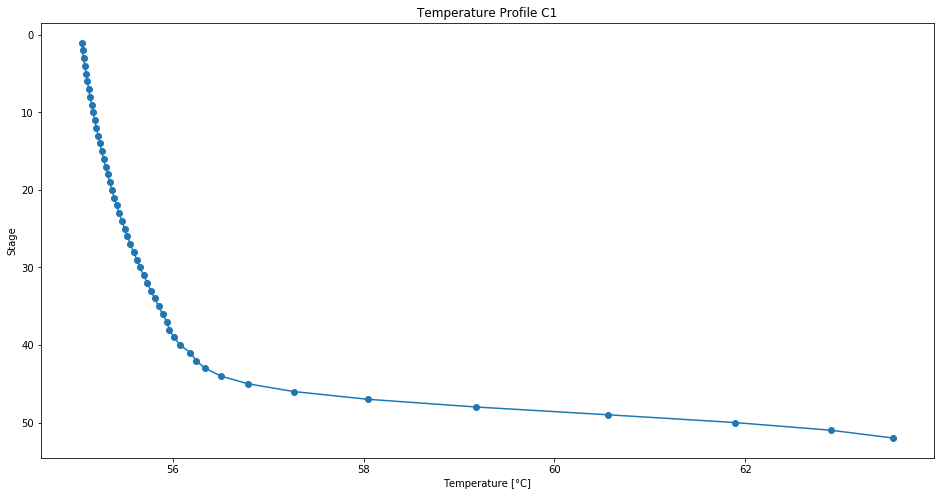

In [23]:
tprof=C1.GetProfile("T")
stages= range(1, C1.NumberOfTrays+1)
df_temp= pd.DataFrame(tprof, index=stages, columns=["T"])
plt.plot( df_temp['T'], stages,  linestyle='-', marker='o')
plt.gca().invert_yaxis()
plt.xlabel("Temperature ["+str(sys.VariableFactory.Output.UnitDictionary[PhysicalDimension.Temperature])+"]");
plt.ylabel("Stage");
plt.title("Temperature Profile C1");


In [24]:
reporter.Report(C1,True)
print(logger.Flush())

     Stage          T         TV          P          Q          L          V          F          W         RL        EPS
                   °C         °C        bar         MW     kmol/h     kmol/h     kmol/h     kmol/h                   [-]
1              55,043     55,043      1,000      0,000   1058,203   1509,498   1060,243      0,000      0,000      1,000
2              55,054     55,054      1,000      0,000   1056,317   1507,459      0,000      0,000      0,000      1,000
3              55,065     55,065      1,000      0,000   1054,555   1505,572      0,000      0,000      0,000      1,000
4              55,078     55,078      1,000      0,000   1052,896   1503,810      0,000      0,000      0,000      1,000
5              55,091     55,091      1,000      0,000   1051,322   1502,151      0,000      0,000      0,000      1,000
6              55,105     55,105      1,000      0,000   1049,819   1500,577      0,000      0,000      0,000      1,000
7              55,119     55,119

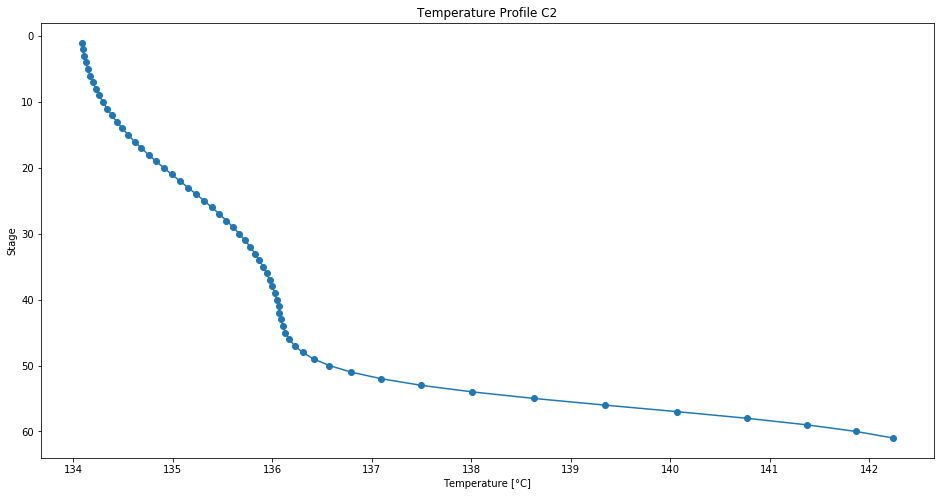

In [25]:
tprof=C2.GetProfile("T")
stages= range(1, C2.NumberOfTrays+1)
df_temp= pd.DataFrame(tprof, index=stages, columns=["T"])
plt.plot( df_temp['T'], stages,  linestyle='-', marker='o')
plt.gca().invert_yaxis()
plt.xlabel("Temperature ["+str(sys.VariableFactory.Output.UnitDictionary[PhysicalDimension.Temperature])+"]");
plt.ylabel("Stage");
plt.title("Temperature Profile C2");

In [26]:
reporter.Report(C2,True)
print(logger.Flush())

     Stage          T         TV          P          Q          L          V          F          W         RL        EPS
                   °C         °C        bar         MW     kmol/h     kmol/h     kmol/h     kmol/h                   [-]
1             134,084    134,084     10,000      0,000    558,585    736,739    557,484      0,000      0,000      1,000
2             134,095    134,095     10,000      0,000    559,698    737,841      0,000      0,000      0,000      1,000
3             134,110    134,110     10,000      0,000    560,827    738,954      0,000      0,000      0,000      1,000
4             134,127    134,127     10,000      0,000    561,976    740,083      0,000      0,000      0,000      1,000
5             134,148    134,148     10,000      0,000    563,148    741,231      0,000      0,000      0,000      1,000
6             134,171    134,171     10,000      0,000    564,346    742,403      0,000      0,000      0,000      1,000
7             134,197    134,197